## Check GPU presence

In [1]:
import sys
print(sys.executable)
print(sys.version)

#import sys
#!{sys.executable} -m pip uninstall torch torchvision torchaudio -y
#!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
import torchvision

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
Torchvision: 0.20.1+cu121
CUDA available: True


In [2]:
from torch.utils.data import Dataset

# Custom Dataset class
class ChipDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Add dtype=torch.long
        return image, label

## Collect / analyze image database

Collect all images in the database, count the number of samples in each brand, and present in a plot. For this model, each model must have a minimum of 20 images to be used.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip --quiet


Found 2059 total images across 141 brands

Total images for training: 1916


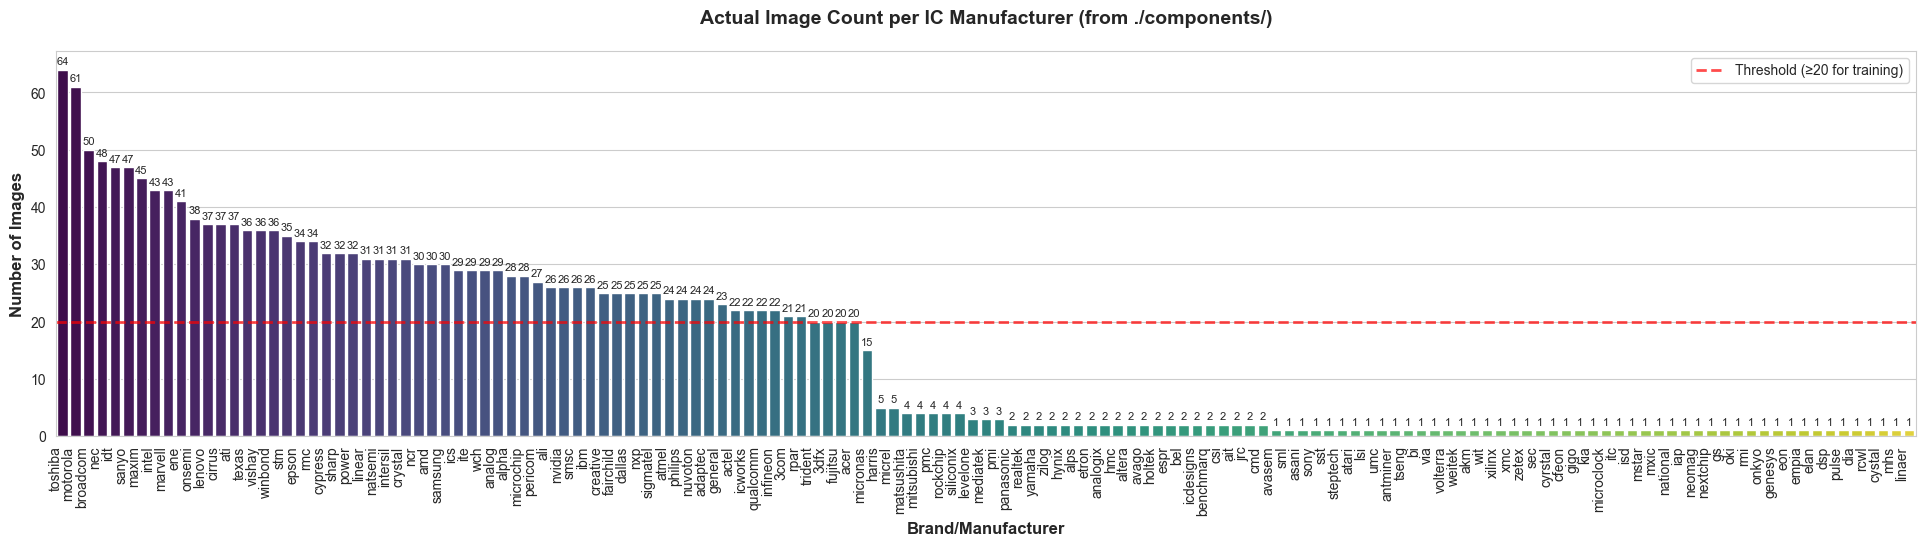

In [3]:
!pip install --upgrade pip --quiet

# Section 1: Data Augmentation & Dataset Setup
import os
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define your data directory
DATA_DIR = './components/'

# Scan the directory and build the dataset directly from files
brand_counts = Counter()
all_files = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.png'):
        brand = filename.split('_')[0]
        brand_counts[brand] += 1
        all_files.append(filename)

# Create dataframe from actual files
df = pd.DataFrame([
    {'Brand': brand, 'Moniker': brand, 'Count': count}
    for brand, count in brand_counts.items()
]).sort_values('Count', ascending=False)

print(f"Found {len(all_files)} total images across {len(df)} brands")

# Create visualization
plt.figure(figsize=(24, 5))
sns.set_style("whitegrid")

# Create bar plot
ax = sns.barplot(data=df, x='Brand', y='Count', hue='Brand', palette='viridis', legend=False)

# Customize the plot
plt.xticks(rotation=90, ha='right')
plt.xlabel('Brand/Manufacturer', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Actual Image Count per IC Manufacturer (from ./components/)', fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, v in enumerate(df['Count']):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

# Add threshold line
plt.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (≥20 for training)')
plt.legend()


# Filter to brands with >= 20 images
min_df = df[df['Count'] >= 20].copy()

# Get list of valid brands (these will be your classes)
valid_brands = min_df['Moniker'].tolist()
brand_to_idx = {brand: idx for idx, brand in enumerate(sorted(valid_brands))}
idx_to_brand = {idx: brand for brand, idx in brand_to_idx.items()}

# Collect all valid images (only from brands with >= 20 images)
image_paths = []
labels = []

for filename in all_files:
    brand = filename.split('_')[0]
    
    if brand in brand_to_idx:
        image_paths.append(os.path.join(DATA_DIR, filename))
        labels.append(brand_to_idx[brand])

print(f"\nTotal images for training: {len(image_paths)}")

## Reduce dataset to minimum viable brands

To be used in the model, each brand must contain a minimum of 20 samples. Brands with less than 20 samples are discarded from the dataset.

In [4]:
# Section 3: Download/Build the Model
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Load pretrained ResNet-18
print(f"\n{'='*60}")
print("Loading ResNet-18 with ImageNet pretrained weights...")

model = models.resnet18(pretrained=True)

# Freeze early layers (optional - keeps ImageNet features)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_classes = len(brand_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU/CPU
model = model.to(device)

print(f"Model architecture modified:")
print(f"  Original output: 1000 classes (ImageNet)")
print(f"  New output: {num_classes} classes (IC brands)")
print(f"  Frozen layers: Early conv layers (transfer learning)")
print(f"  Trainable layers: Final FC layer")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print(f"\nTraining configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"\nModel ready for training!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.00 GB

Loading ResNet-18 with ImageNet pretrained weights...


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture modified:
  Original output: 1000 classes (ImageNet)
  New output: 61 classes (IC brands)
  Frozen layers: Early conv layers (transfer learning)
  Trainable layers: Final FC layer

Model parameters:
  Total parameters: 11,207,805
  Trainable parameters: 31,293
  Frozen parameters: 11,176,512

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

Model ready for training!


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Split dataset into train / test / validation (80 / (80/20))

In [5]:
# Section 2: Train/Test/Validation Split with Balanced Sampling
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler

# Convert to numpy arrays for easier manipulation
image_paths = np.array(image_paths)  # FIXED: No dtype for strings
labels = np.array(labels, dtype=np.int64)

print(f"Total dataset: {len(image_paths)} images")
print(f"Number of classes: {len(brand_to_idx)}")

# First split: 80% train+val, 20% test
# Stratify to ensure each brand is represented proportionally in each split
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, 
    labels, 
    test_size=0.2,  # 20% for test
    stratify=labels,  # Maintain class distribution
    random_state=42
)

# Second split: Split train+val into 80% train, 20% val
# From the remaining 80%, take 20% for validation (which is 16% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,  # 20% of train_val = 16% of total
    stratify=train_val_labels,
    random_state=42
)

# Final split: ~64% train, ~16% val, ~20% test
print(f"\n{'='*60}")
print(f"Split Summary:")
print(f"  Training:   {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

# Calculate class weights for balanced sampling
print(f"\n{'='*60}")
print("Setting up balanced sampling for training...")
print(f"{'='*60}")

# Count samples per class in training set
class_counts = {}
for label in train_labels:
    class_counts[label] = class_counts.get(label, 0) + 1

# Calculate sample weights (inverse frequency)
# Classes with fewer samples get higher weight
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow sampling with replacement for balance
)

# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test augmentations
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = ChipDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = ChipDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = ChipDataset(test_paths, test_labels, transform=val_test_transforms)

print(f"\n{'='*60}")
print(f"Datasets created:")
print(f"  Training dataset:   {len(train_dataset)} samples (with augmentation)")
print(f"  Validation dataset: {len(val_dataset)} samples (no augmentation)")
print(f"  Test dataset:       {len(test_dataset)} samples (no augmentation)")

# Create data loaders
BATCH_SIZE = 32

# Training loader uses weighted sampler for balanced class representation
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler instead of shuffle
    num_workers=0,  # Windows fix
    pin_memory=True if torch.cuda.is_available() else False
)

# Validation and test loaders don't need balancing
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches:   {len(train_loader)} (balanced sampling)")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches:       {len(test_loader)}")
print(f"\n{'='*60}")
print("✓ Balanced sampling ensures equal representation during training")
print("✓ Rare classes are sampled more frequently")
print("✓ Common classes are sampled less frequently")
print(f"{'='*60}")

Total dataset: 1916 images
Number of classes: 61

Split Summary:
  Training:   1225 images (63.9%)
  Validation: 307 images (16.0%)
  Test:       384 images (20.0%)

Setting up balanced sampling for training...

Datasets created:
  Training dataset:   1225 samples (with augmentation)
  Validation dataset: 307 samples (no augmentation)
  Test dataset:       384 samples (no augmentation)

DataLoaders created:
  Batch size: 32
  Training batches:   39 (balanced sampling)
  Validation batches: 10
  Test batches:       12

✓ Balanced sampling ensures equal representation during training
✓ Rare classes are sampled more frequently
✓ Common classes are sampled less frequently


## Implement different transfer learning models

In [ ]:
# Section: Multi-Model Comparison
import torch.nn as nn
from torchvision import models
import pandas as pd
import time
from sklearn.metrics import f1_score

# Define models to test
models_to_test = {
    'ResNet-18': lambda: models.resnet18(pretrained=True),
    'ResNet-34': lambda: models.resnet34(pretrained=True),
    'ResNet-50': lambda: models.resnet50(pretrained=True),
    'EfficientNet-B0': lambda: models.efficientnet_b0(pretrained=True),
    'EfficientNet-B2': lambda: models.efficientnet_b2(pretrained=True),
    'EfficientNet-B4': lambda: models.efficientnet_b4(pretrained=True),
    'EfficientNet-B6': lambda: models.efficientnet_b6(pretrained=True),
    'EfficientNet-B7': lambda: models.efficientnet_b7(pretrained=True),    
    'MobileNet-V3': lambda: models.mobilenet_v3_large(pretrained=True),
    'DenseNet-121': lambda: models.densenet121(pretrained=True),
}

results = []
best_overall_f1 = 0.0
best_overall_model_name = None

for model_name, model_fn in models_to_test.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    # Load model
    model = model_fn()
    
    # Modify final layer based on architecture
    num_classes = len(brand_to_idx)
    
    if 'resnet' in model_name.lower():
        # Freeze early layers
        for name, param in model.named_parameters():
            if 'layer1' in name or 'layer2' in name or 'conv1' in name or 'bn1' in name:
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif 'efficientnet' in model_name.lower():
        # Freeze early layers
        for i, child in enumerate(model.features.children()):
            if i < 5:  # Freeze first 5 blocks
                for param in child.parameters():
                    param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif 'mobilenet' in model_name.lower():
        # Freeze early layers
        for i, child in enumerate(model.features.children()):
            if i < 10:  # Freeze first 10 blocks
                for param in child.parameters():
                    param.requires_grad = False
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        
    elif 'densenet' in model_name.lower():
        # Freeze early layers
        for name, param in model.named_parameters():
            if 'denseblock1' in name or 'denseblock2' in name:
                param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0001
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    # Train for fewer epochs (for comparison)
    NUM_EPOCHS = 30
    best_val_acc = 0.0
    
    train_start = time.time()
    
    for epoch in range(NUM_EPOCHS):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels_batch in train_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels_batch.size(0)
            train_correct += (predicted == labels_batch).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()
        
        val_acc = 100 * val_correct / val_total
        scheduler.step(val_loss / len(val_loader))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
    
    train_time = time.time() - train_start
    
    # Test evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels_batch.size(0)
            test_correct += (predicted == labels_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Save this model
    model_filename = f'model_{model_name.lower().replace("-", "_")}.pth'
    torch.save(model.state_dict(), model_filename)
    
    # Track best overall model
    if test_f1 > best_overall_f1:
        best_overall_f1 = test_f1
        best_overall_model_name = model_name
        # Save as best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ New best model saved: {model_filename}")
    
    results.append({
        'Model': model_name,
        'Test Accuracy': f'{test_acc:.2f}%',
        'Test F1': f'{test_f1:.4f}',
        'Best Val Acc': f'{best_val_acc:.2f}%',
        'Total Params': f'{total_params/1e6:.2f}M',
        'Trainable Params': f'{trainable_params/1e6:.2f}M',
        'Training Time': f'{train_time:.1f}s'
    })
    
    print(f"\n{model_name} Results:")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Saved: {model_filename}")
    print(f"  Training Time: {train_time:.1f}s\n")

# Display results table
print(f"\n{'='*80}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*80}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Find best model
best_idx = df_results['Test F1'].str.replace('%', '').astype(float).idxmax()
print(f"\n🏆 Best Model: {df_results.loc[best_idx, 'Model']} "
      f"(Test Acc: {df_results.loc[best_idx, 'Test Accuracy']}, "
      f"F1: {df_results.loc[best_idx, 'Test F1']})")
print(f"✓ Best model saved as: best_model.pth")


Training ResNet-18



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=61.71%, Val Acc=40.39%


## Deep dive analysis

In [ ]:
# Section: Deep Dive Analysis - Success vs Failure Cases

import torch.nn.functional as F
from PIL import Image
import cv2
import glob

# Find the best model file
BEST_MODEL_PATH = 'best_model.pth'
if not os.path.exists(BEST_MODEL_PATH):
    raise FileNotFoundError(f"Model file '{BEST_MODEL_PATH}' not found!")

print(f"Found model file: {BEST_MODEL_PATH}")
print("Loading best model (DenseNet-121) for analysis...")

# Load your best model (DenseNet-121 since it had highest F1)
best_model = models.densenet121(pretrained=True)

# Freeze early layers
for name, param in best_model.named_parameters():
    if 'denseblock1' in name or 'denseblock2' in name:
        param.requires_grad = False

# Replace classifier
best_model.classifier = nn.Linear(best_model.classifier.in_features, num_classes)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))
best_model.eval()

# Initialize GradCAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.cpu().numpy()

# For DenseNet, use the last dense block
gradcam = GradCAM(best_model, best_model.features.denseblock4.denselayer16.conv2)

# Get predictions and confidences for all test samples
print("\nAnalyzing test set predictions...")
test_results = []

with torch.no_grad():
    for idx in range(len(test_paths)):
        img_path = test_paths[idx]
        true_label = test_labels[idx]
        
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_test_transforms(img).unsqueeze(0).to(device)
        
        output = best_model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        
        is_correct = (pred_label.item() == true_label)
        
        test_results.append({
            'idx': idx,
            'path': img_path,
            'true_label': true_label,
            'pred_label': pred_label.item(),
            'confidence': confidence.item(),
            'is_correct': is_correct
        })

# Sort by confidence
test_results.sort(key=lambda x: x['confidence'], reverse=True)

# Get top 5 most confident CORRECT predictions
correct_results = [r for r in test_results if r['is_correct']]
top_5_correct = correct_results[:5]

# Get top 5 most confident INCORRECT predictions (worst failures)
incorrect_results = [r for r in test_results if not r['is_correct']]
top_5_incorrect = incorrect_results[:5] if len(incorrect_results) >= 5 else incorrect_results

print(f"\nFound {len(correct_results)} correct predictions")
print(f"Found {len(incorrect_results)} incorrect predictions")

# ============================================================
# 1. ATTENTION MAPS: Top 5 Most Successful Predictions
# ============================================================
print("\n" + "="*60)
print("GENERATING ATTENTION MAPS: TOP 5 SUCCESSFUL PREDICTIONS")
print("="*60)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Top 5 Most Confident Correct Predictions', fontsize=16, fontweight='bold')

for col, result in enumerate(top_5_correct):
    img_path = result['path']
    true_label = result['true_label']
    pred_label = result['pred_label']
    confidence = result['confidence']
    
    true_brand = idx_to_brand[true_label]
    
    # Load image
    img_orig = Image.open(img_path).convert('RGB')
    img_tensor = val_test_transforms(img_orig).unsqueeze(0).to(device)
    
    # Generate GradCAM
    cam = gradcam.generate_cam(img_tensor, pred_label)
    cam_resized = cv2.resize(cam, img_orig.size)
    
    # Create overlay
    img_np = np.array(img_orig) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.6 * img_np + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Plot original
    axes[0, col].imshow(img_orig)
    axes[0, col].set_title(f'{true_brand}\nConf: {confidence*100:.1f}%', 
                           fontsize=10, fontweight='bold', color='green')
    axes[0, col].axis('off')
    
    # Plot heatmap
    axes[1, col].imshow(cam_resized, cmap='jet')
    axes[1, col].set_title('Attention', fontsize=9)
    axes[1, col].axis('off')
    
    # Plot overlay
    axes[2, col].imshow(overlay)
    axes[2, col].set_title('Focus Areas', fontsize=9)
    axes[2, col].axis('off')

plt.tight_layout()
plt.savefig('analysis_top5_successful.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# 2. ATTENTION MAPS: Top 5 Least Successful Predictions
# ============================================================
if len(top_5_incorrect) > 0:
    print("\n" + "="*60)
    print("GENERATING ATTENTION MAPS: TOP 5 FAILED PREDICTIONS")
    print("="*60)
    
    n_to_show = len(top_5_incorrect)
    fig, axes = plt.subplots(3, n_to_show, figsize=(4*n_to_show, 12))
    if n_to_show == 1:
        axes = axes.reshape(-1, 1)
    fig.suptitle('Most Confident Incorrect Predictions (Failures)', fontsize=16, fontweight='bold')
    
    for col, result in enumerate(top_5_incorrect):
        img_path = result['path']
        true_label = result['true_label']
        pred_label = result['pred_label']
        confidence = result['confidence']
        
        true_brand = idx_to_brand[true_label]
        pred_brand = idx_to_brand[pred_label]
        
        # Load image
        img_orig = Image.open(img_path).convert('RGB')
        img_tensor = val_test_transforms(img_orig).unsqueeze(0).to(device)
        
        # Generate GradCAM
        cam = gradcam.generate_cam(img_tensor, pred_label)
        cam_resized = cv2.resize(cam, img_orig.size)
        
        # Create overlay
        img_np = np.array(img_orig) / 255.0
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.6 * img_np + 0.4 * heatmap
        overlay = np.clip(overlay, 0, 1)
        
        # Plot original
        axes[0, col].imshow(img_orig)
        axes[0, col].set_title(f'True: {true_brand}\nPred: {pred_brand}\nConf: {confidence*100:.1f}%', 
                               fontsize=9, fontweight='bold', color='red')
        axes[0, col].axis('off')
        
        # Plot heatmap
        axes[1, col].imshow(cam_resized, cmap='jet')
        axes[1, col].set_title('Attention', fontsize=9)
        axes[1, col].axis('off')
        
        # Plot overlay
        axes[2, col].imshow(overlay)
        axes[2, col].set_title('Wrong Focus?', fontsize=9)
        axes[2, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('analysis_top5_failures.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\n✨ Perfect model! No incorrect predictions found!")

# ============================================================
# 3. CONFIDENCE SCORE DISTRIBUTION
# ============================================================
print("\n" + "="*60)
print("PLOTTING CONFIDENCE SCORE DISTRIBUTION")
print("="*60)

correct_confidences = [r['confidence'] for r in test_results if r['is_correct']]
incorrect_confidences = [r['confidence'] for r in test_results if not r['is_correct']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(correct_confidences, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Scatter plot
indices = np.arange(len(test_results))
colors = ['green' if r['is_correct'] else 'red' for r in test_results]
confidences = [r['confidence'] for r in test_results]

axes[1].scatter(indices, confidences, c=colors, alpha=0.6, s=50)
axes[1].axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='50% Threshold')
axes[1].set_xlabel('Test Sample Index', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Confidence by Sample', fontsize=14, fontweight='bold')
axes[1].legend(['50% Threshold', 'Correct', 'Incorrect'], fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*60)
print("CONFIDENCE STATISTICS")
print("="*60)
print(f"\nCorrect Predictions:")
print(f"  Count: {len(correct_confidences)}")
print(f"  Mean confidence: {np.mean(correct_confidences)*100:.2f}%")
print(f"  Median confidence: {np.median(correct_confidences)*100:.2f}%")
print(f"  Min confidence: {np.min(correct_confidences)*100:.2f}%")
print(f"  Max confidence: {np.max(correct_confidences)*100:.2f}%")

if len(incorrect_confidences) > 0:
    print(f"\nIncorrect Predictions:")
    print(f"  Count: {len(incorrect_confidences)}")
    print(f"  Mean confidence: {np.mean(incorrect_confidences)*100:.2f}%")
    print(f"  Median confidence: {np.median(incorrect_confidences)*100:.2f}%")
    print(f"  Min confidence: {np.min(incorrect_confidences)*100:.2f}%")
    print(f"  Max confidence: {np.max(incorrect_confidences)*100:.2f}%")
    
    overconfident_errors = sum(1 for c in incorrect_confidences if c > 0.7)
    if overconfident_errors > 0:
        print(f"\n⚠️  Model is overconfident on {overconfident_errors} incorrect predictions (>70% confidence)")

print("\n" + "="*60)
print("✓ Analysis complete! Check saved images:")
print("  - analysis_top5_successful.png")
print("  - analysis_top5_failures.png")
print("  - analysis_confidence_distribution.png")
print("="*60)